In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3

# 导入数据 #

从数据库读取文件

In [5]:
# 从当前路径的数据库文件（dataport_sqlite）读取数据 
cwd = os.getcwd()
conn = sqlite3.connect(str(cwd) + "/dataport_sqlite") 
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

In [6]:
loads_df = pd.DataFrame(data, columns=['id','date','energy_use'])
loads_df.head()

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


数据中，id代表不同的用户；date代表时间，每15min采集一次；energy_use代表测量的电量，以kW表示。

In [7]:
#查看数据量
print("当前数据集含有%s行,%s列"%(loads_df.shape[0],loads_df.shape[1]))

当前数据集含有646981行,3列


In [8]:
#再查看采集数据的最晚时间和最早时间
print(" 最早时间: %s \n 最晚时间: %s"%(loads_df.date.min(),loads_df.date.max()))

 最早时间: 2015-07-01 00:00:00 
 最晚时间: 2015-08-01 00:00:00


In [9]:
#查看id，有多少户
loads_df['id'].value_counts()

26      2977
2859    2977
2667    2977
2710    2977
2742    2977
        ... 
3652    2604
297     1660
490     1447
2974    1188
1508     107
Name: id, Length: 220, dtype: int64

# 数据清洗 #

删除数据中的空缺值

In [10]:
#先查询数据中的空缺值
loads_df = loads_df.replace('',np.nan)
loads_df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

In [11]:
#删除空缺值
#然后输出删除后的表格信息
loads_df = loads_df.dropna()
loads_df.shape

(636286, 3)

删除后还有636286行数据

In [13]:
#drop_duplicates()是数据去重方法
time=loads_df.time.drop_duplicates().sort_values()

改变数据类型

In [14]:
loads_df.loc[:,'energy_use'] = loads_df.energy_use.astype(float) 

loads_df.loc[:,'id'] = loads_df['id'].astype(int) 

loads_df.loc[:,'date'] = pd.to_datetime(loads_df.date) 

In [15]:
loads_df.head()

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.409067
1,26,2015-07-31 23:45:00,3.138733
2,26,2015-07-31 23:30:00,4.202133
3,26,2015-07-31 23:15:00,4.241800
4,26,2015-07-31 23:00:00,4.285733


# 特征工程 #

上述数据的时间仅为一列，无法较好的反映工作日与周末及每月具体日期的区别，因此尝试添加列进一步细化日期

In [16]:
# 添加一代表星期的列
# lamba匿名函数
loads_df.loc[:,'type_day'] = loads_df.date.apply(lambda x: x.isoweekday()) 

# 添加一代表日期的列
loads_df.loc[:,'day_of_month'] = loads_df.date.apply(lambda x: x.day) 

# 按照id和日期进行重新排序
loads_df = loads_df.sort_values(['id', 'date'], ascending=[True, True])
loads_df = loads_df.reset_index(drop=True)

In [17]:
loads_df.head()

,id,date,energy_use,type_day,day_of_month
0,26,2015-07-01 00:00:00,1.571533,3,1
1,26,2015-07-01 00:15:00,0.871400,3,1
2,26,2015-07-01 00:30:00,1.571933,3,1
3,26,2015-07-01 00:45:00,3.406000,3,1
4,26,2015-07-01 01:00:00,3.417467,3,1


过滤周末，以便用户习惯更加一致，便于聚类

In [19]:
loads_df=loads_df[loads_df.type_day<=5]

改变数据结构，获得不同时间下的用户用电数据

In [20]:
# 按照日期和时间绘制数据透视表
loads_wide_df=pd.pivot_table(data=loads_df,columns=['date','day_of_month'],values='energy_use',index=['id'])

In [21]:
loads_wide_df.head()

date,2015-07-01 00:00:00,2015-07-01 00:15:00,2015-07-01 00:30:00,2015-07-01 00:45:00,2015-07-01 01:00:00,2015-07-01 01:15:00,2015-07-01 01:30:00,2015-07-01 01:45:00,2015-07-01 02:00:00,2015-07-01 02:15:00,...,2015-07-31 21:30:00,2015-07-31 21:45:00,2015-07-31 22:00:00,2015-07-31 22:15:00,2015-07-31 22:30:00,2015-07-31 22:45:00,2015-07-31 23:00:00,2015-07-31 23:15:00,2015-07-31 23:30:00,2015-07-31 23:45:00
day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,31,31,31,31,31,31,31,31
id,,,,,,,,,,,,,,,,,,,,,
26,1.571533,0.871400,1.571933,3.406000,3.417467,2.583333,0.837867,0.790133,0.834733,0.868467,...,4.480667,4.474867,4.574867,4.448933,5.134600,4.505933,4.285733,4.241800,4.202133,3.138733
59,0.986667,0.947133,0.901800,0.896733,1.008133,0.841067,0.915400,0.851467,1.050067,0.872133,...,3.499867,2.251333,3.897800,3.797467,2.279867,3.671600,1.521000,2.790000,2.836133,1.430867
68,0.318400,0.298733,0.250000,0.263667,0.325467,0.263267,0.250000,0.314333,0.318200,0.278733,...,0.218200,0.237733,0.288533,0.286933,0.251200,0.219000,0.236600,0.296800,0.243600,0.224400
77,0.340333,0.442933,0.444133,0.389467,0.406067,0.434400,0.367333,0.391267,0.523733,0.558467,...,2.351200,2.667533,3.279867,1.999000,2.049467,3.172933,1.993067,2.056200,2.950867,0.690400
86,0.208467,0.213467,0.211067,0.250800,0.320533,0.323133,0.310733,0.300333,0.291600,0.230667,...,2.897400,3.641267,1.874733,1.219800,3.598200,1.756267,1.470400,3.479733,0.576800,2.025467


In [22]:
# 取7月7日当天数据进行分析
unique_days = loads_df.day_of_month.unique()
loads_wide_df = pd.concat([loads_wide_df.xs(7,level='day_of_month',axis=1) for day in unique_days])

In [23]:
loads_wide_df=loads_wide_df.drop_duplicates()
loads_wide_df.head()

date,2015-07-07 00:00:00,2015-07-07 00:15:00,2015-07-07 00:30:00,2015-07-07 00:45:00,2015-07-07 01:00:00,2015-07-07 01:15:00,2015-07-07 01:30:00,2015-07-07 01:45:00,2015-07-07 02:00:00,2015-07-07 02:15:00,...,2015-07-07 21:30:00,2015-07-07 21:45:00,2015-07-07 22:00:00,2015-07-07 22:15:00,2015-07-07 22:30:00,2015-07-07 22:45:00,2015-07-07 23:00:00,2015-07-07 23:15:00,2015-07-07 23:30:00,2015-07-07 23:45:00
id,,,,,,,,,,,,,,,,,,,,,
26,4.098000,4.178467,3.352333,1.511733,0.965667,1.369467,3.644400,3.573400,3.509067,2.774933,...,1.543800,2.279000,4.438267,4.356200,4.306667,4.361400,3.902800,3.738600,3.6216,3.599200
59,1.628933,0.511533,1.446200,0.742267,0.526000,1.657000,0.423867,1.359667,0.731067,0.502067,...,1.220800,1.995867,1.467133,1.920333,0.550400,1.601200,0.812333,1.252933,1.2064,0.468733
68,0.290000,0.254400,0.284067,0.320733,0.304000,0.251800,0.256733,0.322200,0.511800,0.373067,...,0.460267,0.355667,0.352200,0.320333,0.272067,0.272000,0.345333,0.315800,0.3468,0.322933
77,2.659400,2.338533,1.102200,1.801067,1.793000,1.470933,0.895933,1.508067,0.676133,1.315800,...,2.222267,1.165400,2.293333,2.121467,1.482267,1.459533,1.934933,2.017267,0.9942,1.606000
86,0.320133,0.289933,0.195267,0.194133,0.190600,0.287667,1.886733,0.313733,0.294533,0.210867,...,7.676067,6.202867,4.919667,2.975267,1.655133,1.737000,1.771133,1.761800,1.7558,1.750933


In [24]:
#查看缺失值，其中T代表将原有矩阵转置
loads_wide_df.T.isnull().sum().sort_values(ascending=False).head()

id
1508    96
26       0
2907     0
2742     0
2751     0
dtype: int64

用户1508缺失所有数据，将其删除

In [25]:
loads_wide_df = loads_wide_df.dropna(axis=0,how='any')

In [26]:
loads_wide_df.shape

(215, 96)

根据当前结果，绘制当日不同时间不同用户的用电特征曲线

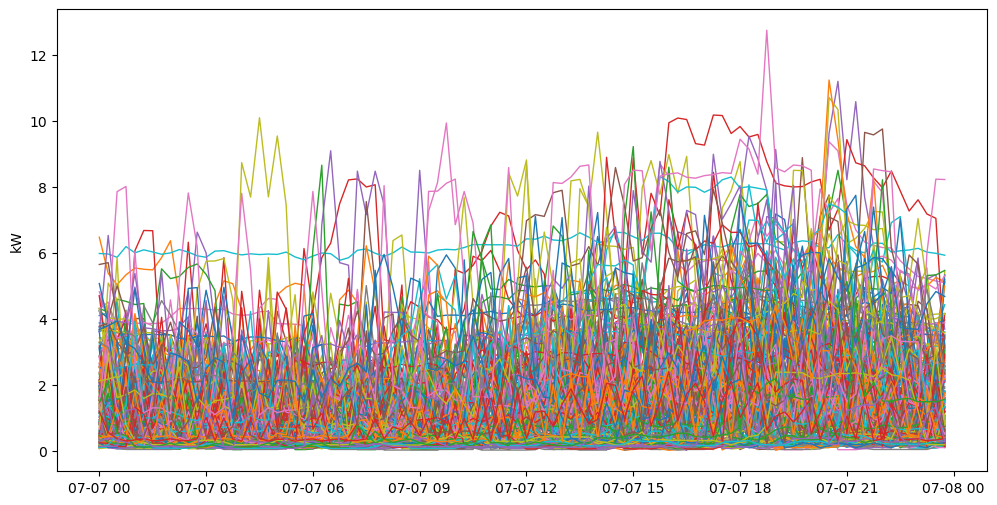

In [27]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(loads_wide_df.T,alpha=1,lw=1)
plt.ylabel('kW')
plt.show()

可见没有聚类处理之前画出的用电图杂乱无章，完全看不出规律

# 聚类模型 #

In [34]:
from sklearn.cluster import KMeans

class EnergyFingerPrints():
     
    def __init__(self,data):
        # 存储每个聚类中心的值
        self.means = [] 
        self.data = data

    # 实现肘部法则，帮助确定最佳聚类数量
    def elbow_method(self,n_clusters):
        """Performs elbow method for a predefined number
        of clusters.
        
        Parameters
        ----------
        n_clusters : int
            the number of clusters to perform the elbow method
        
        Returns
        ---------
        A plot the of elbow method
        """
        fig,ax=plt.subplots(figsize=(8,4)) 
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++', #初始中心簇的获取方式，k-means++一种比较快的收敛的方法
                        n_init=10,        #初始中心簇的迭代次数
                        max_iter=300,     #数据分类的迭代次数
                        random_state=0)   #初始化中心簇的方式
            km.fit(self.data)
            distortions.append(km.inertia_) #inertia计算样本点到最近的中心点的距离之和
        
        plt.plot(range(1,n_clusters), distortions, marker='o',lw=1)
        plt.xlabel('Number of clusters')
        plt.ylabel('The sum of distances to the center point')
        plt.show() 
        
    # 返回一个Series，展示了各个聚类中样本的数量，有助于了解数据分布
    def get_cluster_counts(self):
        return pd.Series(self.predictions).value_counts()
    
    # 给定聚类数量后，对数据执行K-Means聚类并返回每个样本的聚类标签
    def labels(self,n_clusters):
        self.n_clusters = n_clusters
        return KMeans(self.n_clusters, init='k-means++', n_init=10,max_iter=300,random_state=0).fit(self.data).labels_
    
    #根据给定的聚类数量n_clusters对数据进行聚类，并存储预测的聚类标签
    def fit(self,n_clusters):
        """Performs K-means clustering for the load-profiles
        
        Parameters
        ----------
        n_clusters : int
        
        Returns
        --------
        count_dict : dict
            The number of load-profiles in each cluster
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

        
    # 绘制每个聚类中的所有样本曲线及每个聚类的平均曲线
    def plot(self):
        """Plots all loads in each cluster"""
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        fig,ax=plt.subplots(figsize=(12,16))

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.06,color="blue",lw=2)
                        #plt.ylim(0,4)
                        plt.xlim(0,96)
                        plt.title('Cluster%s'%(i+1))
                        plt.ylabel('Electricity consumption/kW')
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
        plt.show()
        
        
    # 在单个图表中绘制每个聚类的平均能源消耗曲线
    def plot_energy_fingerprints(self):
        """Plots the mean of each cluster in single plot"""
        fig,ax=plt.subplots(figsize=(8,5))
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster %s"%(str(i+1)))
            plt.xlim(0,96)
        plt.ylabel('Electricity consumption/kW')
        plt.xticks([0,20,40,60,80],['00:00','05:00','10:00','15:00','20:00'],rotation=60)
        plt.grid()
        plt.legend()
        plt.show()

# 聚类分析 #

In [29]:
load_data=np.array(loads_wide_df)

导入数据，生成计算模型

In [36]:
energy_clusters = EnergyFingerPrints(load_data)

计算聚类簇的距离

D:\APP\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


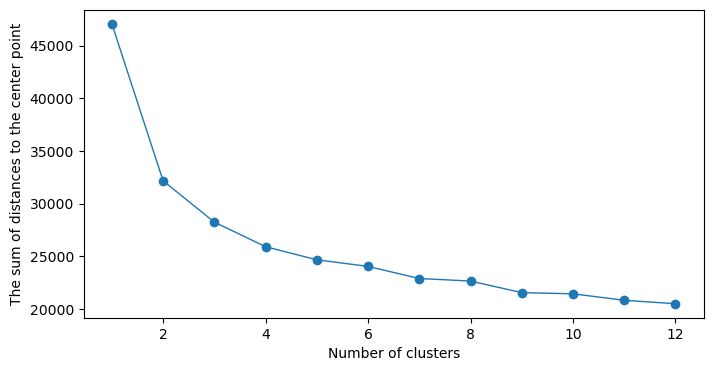

In [37]:
energy_clusters.elbow_method(n_clusters=13)

显然，随着聚类簇数n的增加，样本点至中心簇间的距离逐渐减小。
这里，我们取n=4为拐点。

In [38]:
energy_clusters.fit(n_clusters = 4)

模型结果分组

In [39]:
energy_clusters.get_cluster_counts()

0    93
2    74
3    41
1     7
dtype: int64

In [40]:
group=energy_clusters.labels(n_clusters = 4)

In [41]:
num=loads_wide_df.index

In [42]:
cls=pd.DataFrame(list(num))
cls['cluster']=list(group)
cls.columns=['user_id','cluster']
#通过排序可以得到每个类中的用户id
cls=cls.sort_values(by='cluster',ascending=True)
cls.reset_index(drop=True)

,user_id,cluster
0,3394,0
1,604,0
2,3126,0
3,974,0
4,3916,0
...,...,...
210,2641,3
211,2575,3
212,2557,3
213,3224,3


In [43]:
#获得属于第一分类簇的用户id
np.array(cls.loc[cls.cluster ==0].user_id)

array([3394,  604, 3126,  974, 3916, 3401, 1507], dtype=int64)

In [44]:
#获得属于第二分类簇的用户id
np.array(cls.loc[cls.cluster ==1].user_id)

array([1185, 2638, 2710, 2814, 2980, 3044, 3221,  545, 3367, 2925, 2472,
        661, 2335, 1392, 2242, 2233, 2171, 2094, 2072, 1589, 2018, 1830,
       1801, 1697, 1790, 1202, 1283, 1718,  222, 3795,  434,  370,  187,
       3918, 3635, 3500,   86, 3652, 3953,  252,  490,  503], dtype=int64)

In [45]:
#获得属于第三分类簇的用户id
np.array(cls.loc[cls.cluster ==2].user_id)

array([2401, 3831, 2337, 3687, 2207, 3368, 3849, 2470, 3873, 2075, 3886,
       4031, 3935, 1879, 1832, 3938, 4022, 2199, 3864, 2606, 2667, 3443,
       3299, 3273, 3268, 3456, 3134, 3482, 3104, 1766, 3510, 3036, 2992,
       2953, 2945, 2931, 3531, 2859, 2829, 2751, 3538, 3631, 3678, 2034,
       4042,  575, 1334,  772,  491,  203,  232,  267, 1310, 1192,  573,
        821,  297, 1169, 1103,  364,  994,  871,  954,  484,  436,  946,
        457,  936, 1731, 1350, 1450,  585,  624,   68,  645,  547,   94,
       1642,  101, 1415,  115,  516,  130, 1586, 1577, 1524,  160,  507,
        171, 1500,  739,  470], dtype=int64)

In [46]:
#获得属于第四分类簇的用户id
np.array(cls.loc[cls.cluster ==3].user_id)

array([3310, 3413,  499,  483, 3392, 1714, 3527,   59, 3967,   77,   93,
       3893,  114,  121, 3506, 3829, 3736, 3723, 3721, 3719,  275, 3577,
        410, 3778, 3649, 2986,  580, 2378, 2365, 2361, 1403, 1463, 2158,
       2156, 2129, 1617, 1314, 1629, 1953, 1947, 1632, 1681, 1696, 1800,
       1792, 1791, 1700, 2004, 2449, 2461, 2532, 3192, 3092,  668, 3039,
       3009,  744, 2965,  781,  861, 2907, 2864,  890, 2818, 2787, 2769,
       2755, 2742, 1086, 2641, 2575, 2557, 3224,   26], dtype=int64)

各组用电数据曲线对比

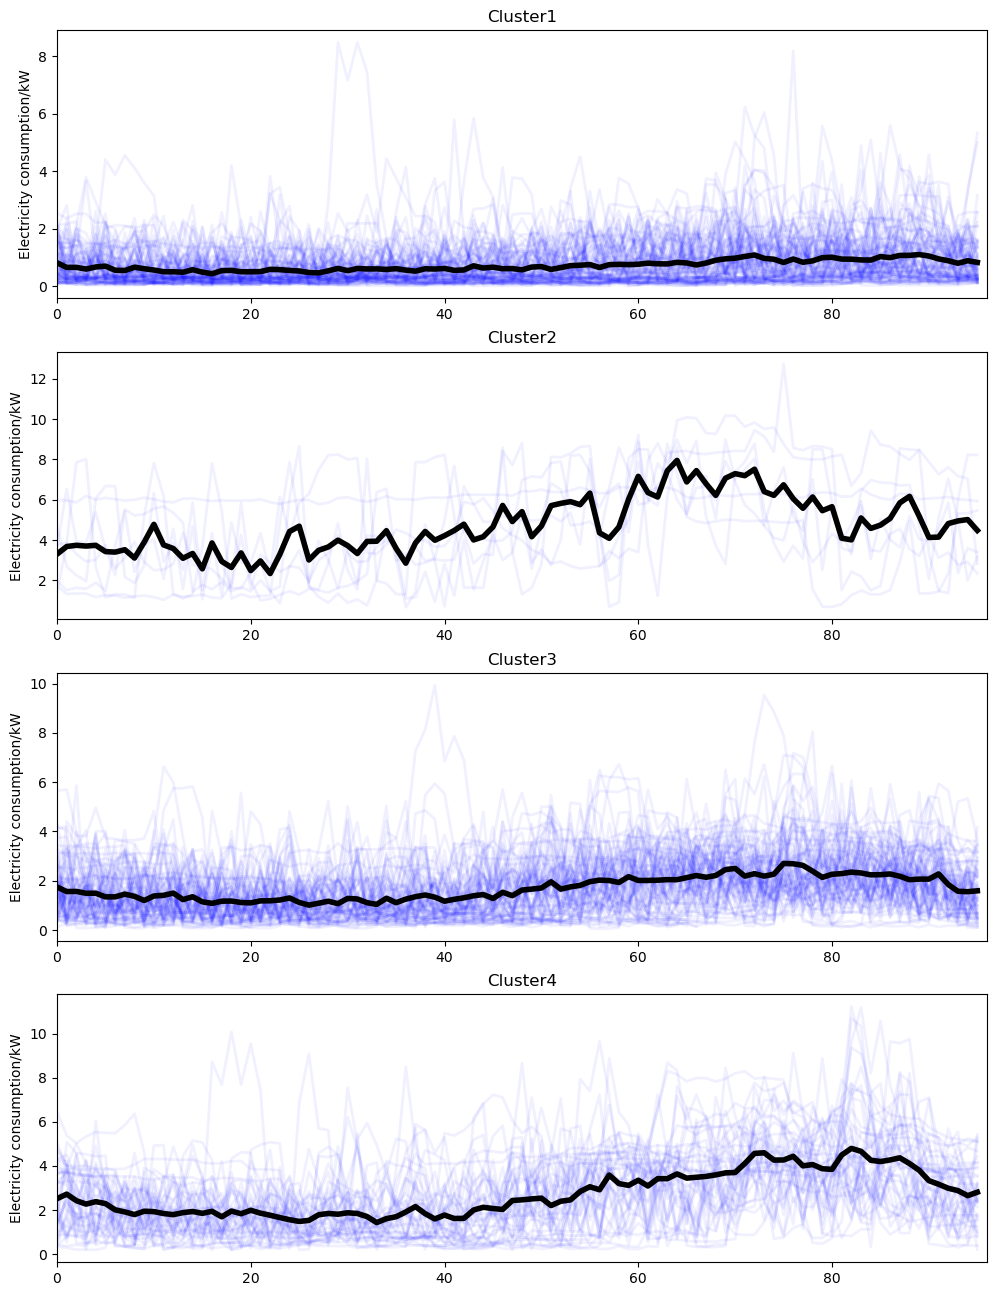

In [47]:
energy_clusters.plot()

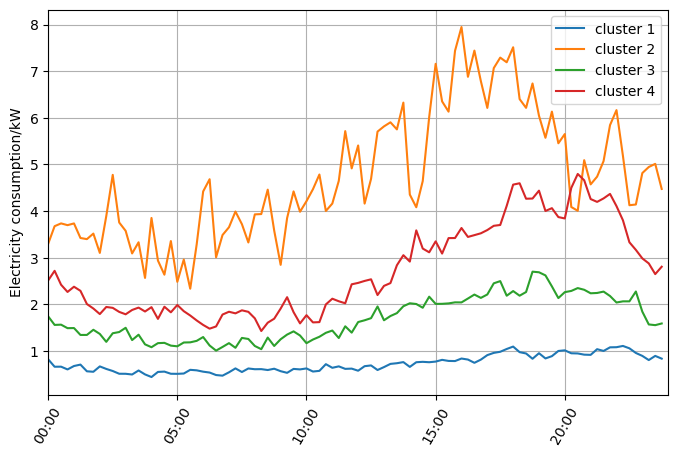

In [48]:
energy_clusters.plot_energy_fingerprints()